# Lesson 3: Exercises

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Model templates

Again, we start with defining a function that creates a pre-configured model model to reduce the amount of required typing.

In [2]:
# Do not delete!
def create_cstr_template(kfwd, kbwd, stoich, V, init_c, t_cycle):
    n_comp = len(init_c)
    
    model = get_cadet_template(n_units=1)

    # CSTR
    model.root.input.model.unit_000.unit_type = 'CSTR'
    model.root.input.model.unit_000.ncomp = n_comp
    model.root.input.model.unit_000.init_volume = V
    model.root.input.model.unit_000.init_c = init_c

    model.root.input.model.unit_000.adsorption_model = 'NONE'

    # Reaction
    model.root.input.model.unit_000.reaction_model = 'MASS_ACTION_LAW'
    model.root.input.model.unit_000.reaction_bulk.mal_kfwd_bulk = kfwd
    model.root.input.model.unit_000.reaction_bulk.mal_kbwd_bulk = kbwd
    model.root.input.model.unit_000.reaction_bulk.mal_stoichiometry_bulk = stoich 

    # Sections and Switches
    model.root.input.solver.sections.nsec = 1
    model.root.input.solver.sections.section_times = [0.0, t_cycle]

    model.root.input.model.connections.nswitches = 1
    model.root.input.model.connections.switch_000.section = 0
    model.root.input.model.connections.switch_000.connections = []

    
    return model


def plot_cstr_results(model):
    time = model.root.output.solution.solution_times
    c = model.root.output.solution.unit_000.solution_bulk
    
    plt.plot(time, c)
    plt.title('CSTR (Bulk)')
    plt.xlabel('$time~/~min$')
    plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
    plt.show()

In [3]:
# Do not delete!
def create_column_template(kfwd, kbwd, stoich, Q, c_feed, t_cycle):
    n_comp = len(c_feed)
    
    model = get_cadet_template(n_units=3)
    
    # Unit Operations
    ## Inlet
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = n_comp
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

    model.root.input.model.unit_000.sec_000.const_coeff = c_feed
    model.root.input.model.unit_000.sec_000.lin_coeff = n_comp*[0.0]
    model.root.input.model.unit_000.sec_000.quad_coeff = n_comp*[0.0]
    model.root.input.model.unit_000.sec_000.cube_coeff = n_comp*[0.0]

    # Tubular reactor
    model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITH_PORES'
    model.root.input.model.unit_001.ncomp = n_comp
    model.root.input.model.unit_001.col_length = 0.5
    model.root.input.model.unit_001.cross_section_area = 0.1
    model.root.input.model.unit_001.col_porosity = 1
    model.root.input.model.unit_001.par_porosity = 1
    model.root.input.model.unit_001.par_radius = 1e-6
    model.root.input.model.unit_001.col_dispersion = 0
    model.root.input.model.unit_001.film_diffusion = n_comp * [0]
    model.root.input.model.unit_001.init_c = n_comp * [0]
    
    ### Adsorption
    model.root.input.model.unit_001.adsorption_model = 'NONE'

    ### Reaction
    model.root.input.model.unit_001.reaction_model = 'MASS_ACTION_LAW'
    model.root.input.model.unit_001.reaction_bulk.mal_kfwd_bulk = kfwd
    model.root.input.model.unit_001.reaction_bulk.mal_kbwd_bulk = kbwd
    model.root.input.model.unit_001.reaction_bulk.mal_stoichiometry_bulk = stoich
    
    ### Discretization
    model.root.input.model.unit_001.discretization.ncol = 100
    model.root.input.model.unit_001.discretization.nbound = n_comp*[0.0]
    model.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
    model.root.input.model.unit_001.discretization.reconstruction = 'WENO'
    model.root.input.model.unit_001.discretization.gs_type = 1
    model.root.input.model.unit_001.discretization.max_krylov = 0
    model.root.input.model.unit_001.discretization.max_restarts = 10
    model.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

    model.root.input.model.unit_001.discretization.weno.boundary_model = 0
    model.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
    model.root.input.model.unit_001.discretization.weno.weno_order = 3
    

    ## Outlet
    model.root.input.model.unit_002.unit_type = 'OUTLET'
    model.root.input.model.unit_002.ncomp = n_comp


    ## Sections and Switches
    model.root.input.solver.sections.nsec = 1
    model.root.input.solver.sections.section_times = [0.0, t_cycle]
    model.root.input.solver.sections.section_continuity = []

    model.root.input.model.connections.nswitches = 1
    model.root.input.model.connections.switch_000.section = 0
    model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q,
                                                                 1, 2, -1, -1, Q]
    
    return model


def plot_column_results(model):
    time = model.root.output.solution.solution_times
    c = model.root.output.solution.unit_001.solution_outlet
    
    plt.figure()
    plt.plot(time, c)
    plt.title('Column (Outlet)')
    plt.xlabel('$time~/~min$')
    plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
    plt.show()
    
    z = model.root.output.coordinates.unit_001.axial_coordinates
    c = model.root.output.solution.unit_001.solution_bulk[-1,:,:]
    plt.figure()
    plt.plot(z, c)
    plt.title('Column (Bulk)')
    plt.xlabel('$z~/~m$')
    plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
    plt.show()
    

## Exercise 1: Equilibrium reaction with intermediate state

We will consider again consider a batch reaction in a `CSTR` but this time, we will also account for an intermediate state:

$\require{mhchem}$
$$\ce{A <=>[k_{AB}][k_{BA}] B <=>[k_{BC}][k_{CB}] C}$$

***Task:*** Implement the reaction and plot the results. Assume the following values for the rate constants:
- $k_{AB} = 0.080~s^{-1}$
- $k_{BA} = 0.0~s^{-1}$
- $k_{BC} = 0.060~s^{-1}$
- $k_{CB} = 0.0~s^{-1}$

Simulation completed successfully


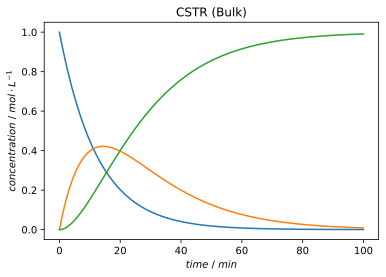

In [4]:
# Auxiliary variables
t_cycle = 100

init_c = [1.0, 0.0, 0.0]
V = 1e-6

k_AB = 0.080
k_BA = 0.0
k_BC = 0.060
k_CB = 0.0

kfwd = [k_AB, k_BC]
kbwd = [k_BA, k_CB]

stoich = [-1,  0, 
           1, -1, 
           0,  1]

# Get simulator object
model = create_cstr_template(kfwd, kbwd, stoich, V, init_c, t_cycle)

# Run simulation and plot results
run_simulation(model)
plot_cstr_results(model)

## Exercise 2: Equilibrium reaction with intermediate state
Again consider the reaction from Exercise 1. 

***Task:*** Implement the reaction in a tubular reactor and plot the results at the outlet, as well as over the length of the column for the last step.


***Hint:*** The path for the coordinates of the column can be looked up [here](https://cadet.github.io/interface/output_group.html).

Simulation completed successfully


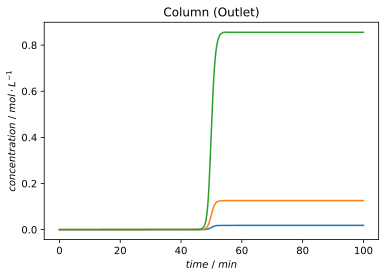

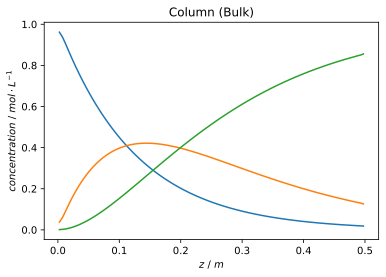

In [5]:
# Auxiliary variables
t_cycle = 100

c_feed = [1.0, 0.0, 0.0]
Q = 1e-3

k_AB = 0.080
k_BA = 0.0
k_BC = 0.060
k_CB = 0.0

kfwd = [k_AB, k_BC]
kbwd = [k_BA, k_CB]

stoich = [-1,  0, 
           1, -1, 
           0,  1]

# Get simulator object
model = create_column_template(kfwd, kbwd, stoich, Q, c_feed, t_cycle)

# Run simulation and plot results
run_simulation(model)
plot_column_results(model)

## Bonus Exercise

Try implementing other reaction systems such as:

$\require{mhchem}$
$$\ce{A + B ->[k_{1}] C}$$
$$\ce{A + B <=>[k_{1}][k_{-1}] C}$$
$$\ce{A + B <=>[k_{1}][k_{-1}] C ->[k_{2}] D}$$
